In [1]:
%matplotlib inline
import sys
from __future__ import division, print_function
%load_ext autoreload
%autoreload 2 
import sys
sys.path.insert(0,'../code')

More Estimation {#more}
===============

The Euro problem {#euro}
----------------

In <span>*Information Theory, Inference, and Learning
Algorithms*</span>, David MacKay poses this problem:

> A statistical statement appeared in \`\`The Guardian" on Friday
> January 4, 2002:
>
> > When spun on edge 250 times, a Belgian one-euro coin came up heads
> > 140 times and tails 110. ‘It looks very suspicious to me,’ said
> > Barry Blight, a statistics lecturer at the London School of
> > Economics. ‘If the coin were unbiased, the chance of getting a
> > result as extreme as that would be less than 7%.’
>
> But do these data give evidence that the coin is biased rather than
> fair?

To answer that question, we’ll proceed in two steps. The first is to
estimate the probability that the coin lands face up. The second is to
evaluate whether the data support the hypothesis that the coin is
biased.

You can download the code in this section from
<http://thinkbayes.com/euro.py>. For more information see
Section [download].

Any given coin has some probability, $x$, of landing heads up when spun
on edge. It seems reasonable to believe that the value of $x$ depends on
some physical characteristics of the coin, primarily the distribution of
weight.

If a coin is perfectly balanced, we expect $x$ to be close to 50%, but
for a lopsided coin, $x$ might be substantially different. We can use
Bayes’s theorem and the observed data to estimate $x$.

Let’s define 101 hypotheses, where $H_x$ is the hypothesis that the
probability of heads is $x$%, for values from 0 to 100. I’ll start with
a uniform prior where the probability of $H_x$ is the same for all $x$.
We’ll come back later to consider other priors.

[Posterior distribution for the Euro problem on a uniform
prior.](figs/euro1.pdf)

[fig.euro1]

The likelihood function is relatively easy: If $H_x$ is true, the
probability of heads is $x/100$ and the probability of tails is $1-
x/100$.

In [2]:
from thinkbayes import Suite
class Euro(Suite):

    def Likelihood(self, data, hypo):
        x = hypo
        if data == 'H':
            return x/100.0
        else:
            return 1 - x/100.0

Here’s the code that makes the suite and updates it:

In [3]:
suite = Euro(range(0, 101))
dataset = 'H' * 140 + 'T' * 110

for data in dataset:
    suite.Update(data)

The result may be plotted with:

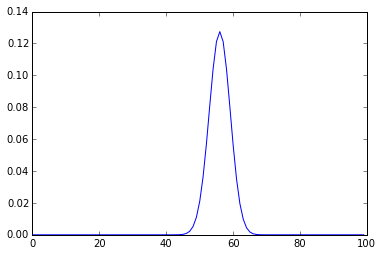

In [4]:
import matplotlib.pyplot as plt  
xs = list(range(0,100))
ps = suite.Probs(xs)
plt.plot(xs, ps);

##Summarizing the posterior

Again, there are several ways to summarize the posterior distribution.
One option is to find the most likely value in the posterior
distribution. `thinkbayes` provides a function that does that:

```python
    def MaximumLikelihood(pmf):
        """Returns the value with the highest probability."""
        prob, val = max((prob, val) for val, prob in pmf.Items())
        return val
```

In [5]:
suite.MaximumLikelihood()

56

In this case the result is 56, which is also the observed percentage of
heads, $140/250 = 56\%$. So that suggests (correctly) that the observed
percentage is the maximum likelihood estimator for the population.

We might also summarize the posterior by computing the mean and median:

In [6]:
import thinkbayes
print('Mean', suite.Mean())
print('Median', thinkbayes.Percentile(suite, 50))

Mean 55.952380952380956
Median 56


Finally, we can compute a credible interval:

In [7]:
print('CI', thinkbayes.CredibleInterval(suite, 90))

CI (51, 61)


Now, getting back to the original question, we would like to know
whether the coin is fair. We observe that the posterior credible
interval does not include 50%, which suggests that the coin is not fair.

But that is not exactly the question we started with. MacKay asked, “ Do
these data give evidence that the coin is biased rather than fair?” To
answer that question, we will have to be more precise about what it
means to say that data constitute evidence for a hypothesis. And that is
the subject of the next chapter.

But before we go on, I want to address one possible source of confusion.
Since we want to know whether the coin is fair, it might be tempting to
ask for the probability that <span>x</span> is 50%:

        print suite.Prob(50)

The result is 0.021, but that value is almost meaningless. The decision
to evaluate 101 hypotheses was arbitrary; we could have divided the
range into more or fewer pieces, and if we had, the probability for any
given hypothesis would be greater or less.

##Swamping the priors {#triangle}

We started with a uniform prior, but that might not be a good choice. I
can believe that if a coin is lopsided, $x$ might deviate substantially
from 50%, but it seems unlikely that the Belgian Euro coin is so
imbalanced that $x$ is 10% or 90%.

It might be more reasonable to choose a prior that gives higher
probability to values of $x$ near 50% and lower probability to extreme
values.

As an example, I constructed a triangular prior. Here’s the code that constructs the prior:

In [8]:
def TrianglePrior(suite):
    for x in range(0, 51):
        suite.Set(x, x)
    for x in range(51, 101):
        suite.Set(x, 100-x) 
    suite.Normalize()
    return suite

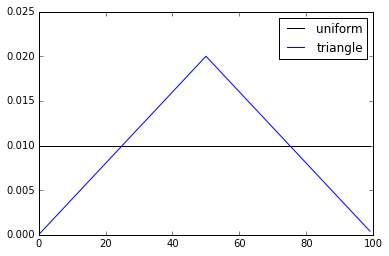

In [9]:
xs = list(range(0,100))

ps = thinkbayes.MakeUniformPmf(0, 100, 101).Probs(xs)
plt.plot(xs, ps, label='uniform', color='k')

suite = TrianglePrior(Euro())
ps = suite.Probs(xs)
plt.plot(xs, ps, label='triangle');
plt.legend();

This shows the result (and the uniform prior for
comparison). Updating this prior with the same dataset yields the
posterior distribution shown in Figure [fig.euro3]. Even with
substantially different priors, the posterior distributions are very
similar. The medians and the credible intervals are identical; the means
differ by less than 0.5%.

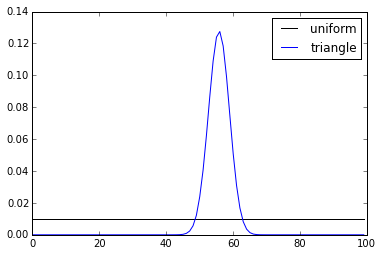

In [10]:
for data in dataset:
    suite.Update(data)
    
ps = thinkbayes.MakeUniformPmf(0, 100, 101).Probs(xs)
plt.plot(xs, ps, label='uniform', color='k')

ps = suite.Probs(xs)
plt.plot(xs, ps, label='triangle');
plt.legend();

This is an example of **swamping the priors** with enough
data, people who start with different priors will tend to converge on
the same posterior.

##Optimization

The code I have shown so far is meant to be easy to read, but it is not
very efficient. In general, I like to develop code that is demonstrably
correct, then check whether it is fast enough for my purposes. If so,
there is no need to optimize. For this example, if we care about run
time, there are several ways we can speed it up.

The first opportunity is to reduce the number of times we normalize the
suite. In the original code, we call `Update` once for each spin.

```python
        dataset = 'H' * heads + 'T' * tails

        for data in dataset:
            suite.Update(data)
```

And here’s what `Update` looks like:

```python
        def Update(self, data):
            for hypo in self.Values():
                like = self.Likelihood(data, hypo)
                self.Mult(hypo, like)
            return self.Normalize()
```

Each update iterates through the hypotheses, then calls `Normalize`,
which iterates through the hypotheses again. We can save some time by
doing all of the updates before normalizing.

`Suite` provides a method called `UpdateSet` that does exactly that.
Here it is:

```
        def UpdateSet(self, dataset):
            for data in dataset:
                for hypo in self.Values():
                    like = self.Likelihood(data, hypo)
                    self.Mult(hypo, like)
            return self.Normalize()
```

And here’s how we can invoke it:

In [11]:
heads, tails = 140, 110

dataset = 'H' * heads + 'T' * tails
suite.UpdateSet(dataset)

2.38031546401283e-75

This optimization speeds things up, but the run time is still
proportional to the amount of data. We can speed things up even more by
rewriting `Likelihood` to process the entire dataset, rather than one
spin at a time.

In the original version, `data` is a string that encodes either heads or
tails:

```python
def Likelihood(self, data, hypo):
    x = hypo / 100.0
    if data == 'H':
        return x
    else:
        return 1-x
```

As an alternative, we could encode the dataset as a tuple of two
integers: the number of heads and tails. In that case `Likelihood` looks
like this:

```python
def Likelihood(self, data, hypo):
    x = hypo / 100.0
    heads, tails = data
    like = x**heads * (1-x)**tails
    return like
```

And then we can call `Update` like this:

In [12]:
heads, tails = 140, 110
suite.Update((heads, tails))

0.4413448096175153

Since we have replaced repeated multiplication with exponentiation, this
version takes the same time for any number of spins.

## The beta distribution

There is one more optimization that solves this problem even faster.

So far we have used a Pmf object to represent a discrete set of values
for $x$. Now we will use a continuous distribution,
specifically the beta distribution (see
<http://en.wikipedia.org/wiki/Beta_distribution>).

The beta distribution is defined on the interval from 0 to 1 (including
both), so it is a natural choice for describing proportions and
probabilities. But wait, it gets better.

It turns out that if you do a Bayesian update with a binomial likelihood
function, as we did in the previous section, the beta distribution is a
<span>**conjugate prior**</span>. That means that if the prior
distribution for <span>x</span> is a beta distribution, the posterior is
also a beta distribution. But wait, it gets even better.

The shape of the beta distribution depends on two parameters, written
$\alpha$ and $\beta$, or <span>alpha</span> and <span>beta</span>. If
the prior is a beta distribution with parameters <span>alpha</span> and
<span>beta</span>, and we see data with <span>h</span> heads and
<span>t</span> tails, the posterior is a beta distribution with
parameters <span>alpha+h</span> and <span>beta+t</span>. In other words,
we can do an update with two additions.

So that’s great, but it only works if we can find a beta distribution
that is a good choice for a prior. Fortunately, for many realistic
priors there is a beta distribution that is at least a good
approximation, and for a uniform prior there is a perfect match. The
beta distribution with <span>alpha=1</span> and <span>beta=1</span> is
uniform from 0 to 1.

Let’s see how we can take advantage of all this.
<span>thinkbayes.py</span> provides a class that represents a beta
distribution:

```python
class Beta(object):

    def __init__(self, alpha=1, beta=1):
        self.alpha = alpha
        self.beta = beta
```

By default `__init__` makes a uniform distribution. <span>Update</span>
performs a Bayesian update:

```python
def Update(self, data):
    heads, tails = data
    self.alpha += heads
    self.beta += tails
```

`data` is a pair of integers representing the number of heads
and tails.

So we have yet another way to solve the Euro problem:

In [13]:
beta = thinkbayes.Beta()
beta.Update((140, 110))
print(beta.Mean())

0.5595238095238095


`Beta` provides `Mean,` which computes a simple
function of `alpha` and `beta`:

```python
def Mean(self):
    return float(self.alpha) / (self.alpha + self.beta)
```

For the Euro problem the posterior mean is 56%, which is the same result
we got using Pmfs.

`Beta` also provides `EvalPdf`, which evaluates
the probability density function (PDF) of the beta distribution:

```python
def EvalPdf(self, x):
    return x**(self.alpha-1) * (1-x)**(self.beta-1)
```

In [14]:
beta.beta

111

In [15]:
beta.EvalPdf(.55)

3.192662744667652e-75

Finally, `Beta` provides `MakePmf`, which uses
`EvalPdf` to generate a discrete approximation of the beta
distribution.

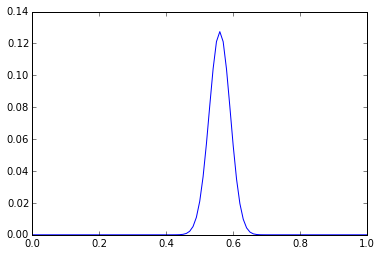

In [16]:
pmf = beta.MakePmf()
xs = [i / 100. for i in range(101)]
ps = pmf.Probs(xs)
plt.plot(xs, ps);

##Discussion

In this chapter we solved the same problem with two different priors and
found that with a large dataset, the priors get swamped. If two people
start with different prior beliefs, they generally find, as they see
more data, that their posterior distributions converge. At some point
the difference between their distribution is small enough that it has no
practical effect.

When this happens, it relieves some of the worry about objectivity that
I discussed in the previous chapter. And for many real-world problems
even stark prior beliefs can eventually be reconciled by data.

But that is not always the case. First, remember that all Bayesian
analysis is based on modeling decisions. If you and I do not choose the
same model, we might interpret data differently. So even with the same
data, we would compute different likelihoods, and our posterior beliefs
might not converge.

Also, notice that in a Bayesian update, we multiply each prior
probability by a likelihood, so if $\mathrm{p}(H)$ is 0,
$\mathrm{p}(H|D)$ is also 0, regardless of $D$. In the Euro
problem, if you are convinced that $x$ is less than 50%, and you assign
probability 0 to all other hypotheses, no amount of data will convince
you otherwise.

This observation is the basis of **Cromwell’s rule**, which
is the recommendation that you should avoid giving a prior probability
of 0 to any hypothesis that is even remotely possible (see
<http://en.wikipedia.org/wiki/Cromwell's_rule>).

Cromwell’s rule is named after Oliver Cromwell, who wrote, “I beseech
you, in the bowels of Christ, think it possible that you may be
mistaken.” For Bayesians, this turns out to be good advice (even if it’s
a little overwrought).

Exercises
---------

Suppose that instead of observing coin tosses directly, you measure the
outcome using an instrument that is not always correct. Specifically,
suppose there is a probability <span>y</span> that an actual heads is
reported as tails, or actual tails reported as heads.

Write a class that estimates the bias of a coin given a series of
outcomes and the value of <span>y</span>.

How does the spread of the posterior distribution depend on
<span>y</span>?

This exercise is inspired by a question posted by a “redditor” named
dominosci on Reddit’s statistics “subreddit” at
<http://reddit.com/r/statistics>.

Reddit is an online forum with many interest groups called subreddits.
Users, called redditors, post links to online content and other web
pages. Other redditors vote on the links, giving an “upvote” to
high-quality links and a “downvote” to links that are bad or irrelevant.

A problem, identified by dominosci, is that some redditors are more
reliable than others, and Reddit does not take this into account.

The challenge is to devise a system so that when a redditor casts a
vote, the estimated quality of the link is updated in accordance with
the reliability of the redditor, and the estimated reliability of the
redditor is updated in accordance with the quality of the link.

One approach is to model the quality of the link as the probability of
garnering an upvote, and to model the reliability of the redditor as the
probability of correctly giving an upvote to a high-quality item.

Write class definitions for redditors and links and an update function
that updates both objects whenever a redditor casts a vote.